In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import gc

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
#
def autocorrelation(ys, t=1):
    return np.corrcoef(ys[:-t], ys[t:])

In [3]:
calendar = pd.read_csv("../m5-forecasting-accuracy/calendar.csv")
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


**Variables to help with aggregation**

In [4]:
def preprocess_sales(sales, start=1400, upper=1970):
    if start is not None:
        print("dropping...")
        to_drop = [f"d_{i+1}" for i in range(start-1)]
        print(sales.shape)
        sales.drop(to_drop, axis=1, inplace=True)
        print(sales.shape)
    
    print("adding...")
    new_columns = ['d_%i'%i for i in range(1942, upper, 1)]
    for col in new_columns:
        sales[col] = np.nan
    print("melting...")
    sales = sales.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id","scale","start"],
                        var_name='d', value_name='demand')

    print("generating order")
    if start is not None:
        skip = start
    else:
        skip = 1
    sales["nb"] =sales.index // 42840 + skip
    return sales

In [5]:
def preprocess_calendar(calendar):
    global maps, mods
    calendar["event_name"] = calendar["event_name_1"]
    calendar["event_type"] = calendar["event_type_1"]

    map1 = {mod:i for i,mod in enumerate(calendar['event_name'].unique())}
    calendar['event_name'] = calendar['event_name'].map(map1)
    map2 = {mod:i for i,mod in enumerate(calendar['event_type'].unique())}
    calendar['event_type'] = calendar['event_type'].map(map2)
    calendar['nday'] = calendar['date'].str[-2:].astype(int)
    maps["event_name"] = map1
    maps["event_type"] = map2
    mods["event_name"] = len(map1)
    mods["event_type"] = len(map2)
    calendar["wday"] -=1
    calendar["month"] -=1
    calendar["year"] -= 2011
    mods["month"] = 12
    mods["year"] = 6
    mods["wday"] = 7
    mods['snap_CA'] = 2
    mods['snap_TX'] = 2
    mods['snap_WI'] = 2

    calendar.drop(["event_name_1", "event_name_2", "event_type_1", "event_type_2", "date", "weekday"], 
                  axis=1, inplace=True)
    return calendar

In [6]:
def make_dataset(categorize=False ,start=1400, upper=1970):
    global maps, mods
    print("loading calendar...")
    calendar = pd.read_csv("../m5-forecasting-accuracy/calendar.csv")
    print("loading sales...")
    sales = pd.read_csv("../m5-forecasting-accuracy/sales_add.csv")
    cols = ["item_id", "dept_id", "cat_id","store_id","state_id"]
    if categorize:
        for col in cols:
            temp_dct = {mod:i for i, mod in enumerate(sales[col].unique())}
            mods[col] = len(temp_dct)
            maps[col] = temp_dct
        for col in cols:
            sales[col] = sales[col].map(maps[col])


    sales =preprocess_sales(sales, start=start, upper= upper)
    calendar = preprocess_calendar(calendar)
    calendar = reduce_mem_usage(calendar)
    print("merge with calendar...")
    sales = sales.merge(calendar, on='d', how='left')
    del calendar

    print("reordering...")
    sales.sort_values(by=["id","nb"], inplace=True)
    print("re-indexing..")
    sales.reset_index(inplace=True, drop=True)
    gc.collect()

    sales['n_week'] = (sales['nb']-1)//7
    sales["nday"] -= 1
    mods['nday'] = 31
    sales = reduce_mem_usage(sales)
    gc.collect()
    return sales

In [7]:
%%time
CATEGORIZE = True;
START = 1000; UPPER = 1970;
maps = {}
mods = {}
sales = make_dataset(categorize=CATEGORIZE ,start=START, upper= UPPER)

loading calendar...
loading sales...
dropping...
(42840, 1949)
(42840, 950)
adding...
melting...
generating order
Mem. usage decreased to  0.04 Mb (78.4% reduction)
merge with calendar...
reordering...
re-indexing..
Mem. usage decreased to 1704.08 Mb (59.8% reduction)
CPU times: user 1min 41s, sys: 1min 3s, total: 2min 44s
Wall time: 2min 57s


In [8]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41554800 entries, 0 to 41554799
Data columns (total 22 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          object 
 1   item_id     int16  
 2   dept_id     int8   
 3   cat_id      int8   
 4   store_id    int8   
 5   state_id    int8   
 6   scale       float16
 7   start       int16  
 8   d           object 
 9   demand      float16
 10  nb          int16  
 11  wm_yr_wk    int16  
 12  wday        int8   
 13  month       int8   
 14  year        int8   
 15  snap_CA     int8   
 16  snap_TX     int8   
 17  snap_WI     int8   
 18  event_name  int8   
 19  event_type  int8   
 20  nday        int8   
 21  n_week      int16  
dtypes: float16(2), int16(5), int8(13), object(2)
memory usage: 1.7+ GB


As we are asked to predict a time window of 28 days, the easiest way to go now is to use the last 28 days for validation:

In [9]:
sales["x"] = sales["demand"] / sales["scale"]

In [10]:
LAGS = [28, 35, 42, 49, 56, 63]
FEATS = []
for lag in tqdm(LAGS):
    sales[f"x_{lag}"] = sales.groupby("id")["x"].shift(lag)
    FEATS.append(f"x_{lag}")

100%|██████████| 6/6 [00:27<00:00,  4.59s/it]


In [11]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41554800 entries, 0 to 41554799
Data columns (total 29 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          object 
 1   item_id     int16  
 2   dept_id     int8   
 3   cat_id      int8   
 4   store_id    int8   
 5   state_id    int8   
 6   scale       float16
 7   start       int16  
 8   d           object 
 9   demand      float16
 10  nb          int16  
 11  wm_yr_wk    int16  
 12  wday        int8   
 13  month       int8   
 14  year        int8   
 15  snap_CA     int8   
 16  snap_TX     int8   
 17  snap_WI     int8   
 18  event_name  int8   
 19  event_type  int8   
 20  nday        int8   
 21  n_week      int16  
 22  x           float16
 23  x_28        float16
 24  x_35        float16
 25  x_42        float16
 26  x_49        float16
 27  x_56        float16
 28  x_63        float16
dtypes: float16(9), int16(5), int8(13), object(2)
memory usage: 2.2+ GB


In [12]:
print(sales.shape)
sales = sales.loc[sales.nb>sales.start]
print(sales.shape)

(41554800, 29)
(39912812, 29)


In [13]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,scale,start,d,demand,...,event_type,nday,n_week,x,x_28,x_35,x_42,x_49,x_56,x_63
0,CA_1_FOODS,3056,7,2,0,0,465.75,0,d_1000,2126.0,...,0,23,142,4.566406,NaN,NaN,NaN,NaN,NaN,NaN
1,CA_1_FOODS,3056,7,2,0,0,465.75,0,d_1001,2828.0,...,0,24,142,6.070312,NaN,NaN,NaN,NaN,NaN,NaN
2,CA_1_FOODS,3056,7,2,0,0,465.75,0,d_1002,3716.0,...,0,25,143,7.980469,NaN,NaN,NaN,NaN,NaN,NaN
3,CA_1_FOODS,3056,7,2,0,0,465.75,0,d_1003,3856.0,...,0,26,143,8.281250,NaN,NaN,NaN,NaN,NaN,NaN
4,CA_1_FOODS,3056,7,2,0,0,465.75,0,d_1004,2730.0,...,0,27,143,5.863281,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
nb = sales['nb'].values
MAX_LAG = max(LAGS)
tr_mask = np.logical_and(nb>START + MAX_LAG, nb<=1941) 
val_mask = np.logical_and(nb>1913, nb<=1941)
te_mask = np.logical_and(nb>1941, nb<=1969)

In [15]:
nb

array([1000, 1001, 1002, ..., 1967, 1968, 1969], dtype=int16)

In [16]:
scale = sales['scale'].values
ids = sales['id'].values
ys = sales['x'].values  # ys = sales['demand']/sales['scale']
Z = sales[FEATS].values

In [17]:
sales['x']

0           4.566406
1           6.070312
2           7.980469
3           8.281250
4           5.863281
              ...   
41554795         NaN
41554796         NaN
41554797         NaN
41554798         NaN
41554799         NaN
Name: x, Length: 39912812, dtype: float16

In [18]:
scale

array([ 465.8,  465.8,  465.8, ..., 1440. , 1440. , 1440. ], dtype=float16)

In [19]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39912812 entries, 0 to 41554799
Data columns (total 29 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          object 
 1   item_id     int16  
 2   dept_id     int8   
 3   cat_id      int8   
 4   store_id    int8   
 5   state_id    int8   
 6   scale       float16
 7   start       int16  
 8   d           object 
 9   demand      float16
 10  nb          int16  
 11  wm_yr_wk    int16  
 12  wday        int8   
 13  month       int8   
 14  year        int8   
 15  snap_CA     int8   
 16  snap_TX     int8   
 17  snap_WI     int8   
 18  event_name  int8   
 19  event_type  int8   
 20  nday        int8   
 21  n_week      int16  
 22  x           float16
 23  x_28        float16
 24  x_35        float16
 25  x_42        float16
 26  x_49        float16
 27  x_56        float16
 28  x_63        float16
dtypes: float16(9), int16(5), int8(13), object(2)
memory usage: 2.4+ GB


In [20]:
sv = scale[val_mask]
se = scale[te_mask]
ids = ids[te_mask]
ids = ids.reshape((-1, 28))

In [21]:
se

array([ 465.8,  465.8,  465.8, ..., 1440. , 1440. , 1440. ], dtype=float16)

In [22]:
ca = sales[['snap_CA']].values
tx = sales[['snap_TX']].values
wi = sales[['snap_WI']].values
wday = sales[['wday']].values
month = sales[['month']].values
year = sales[['year']].values
event = sales[['event_name']].values
nday = sales[['nday']].values
lag1=sales[['x_28']].values

In [23]:
item = sales[['item_id']].values
dept = sales[['dept_id']].values
cat = sales[['cat_id']].values
store = sales[['store_id']].values
state = sales[['state_id']].values

In [24]:
Z.shape

(39912812, 6)

In [25]:
len(FEATS)

6

In [26]:
sales[FEATS]

,x_28,x_35,x_42,x_49,x_56,x_63
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
41554795,7.667969,10.242188,8.625000,6.964844,7.355469,7.562500
41554796,7.988281,9.382812,9.539062,7.234375,7.601562,8.453125
41554797,8.898438,9.218750,9.992188,9.414062,8.890625,10.234375
41554798,10.234375,13.132812,12.125000,10.703125,10.320312,10.648438


In [27]:
ca

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int8)

In [28]:
def make_data(mask):
    x = {"snap_CA":ca[mask], "snap_TX":tx[mask], "snap_WI":wi[mask], "wday":wday[mask], 
         "month":month[mask], "year":year[mask], "event":event[mask], "nday":nday[mask], 
         "item":item[mask], "dept":dept[mask], "cat":cat[mask], "store":store[mask], 
         "state":state[mask],"num":Z[mask]}
    t = ys[mask]
    return x, t

In [29]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39912812 entries, 0 to 41554799
Data columns (total 29 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          object 
 1   item_id     int16  
 2   dept_id     int8   
 3   cat_id      int8   
 4   store_id    int8   
 5   state_id    int8   
 6   scale       float16
 7   start       int16  
 8   d           object 
 9   demand      float16
 10  nb          int16  
 11  wm_yr_wk    int16  
 12  wday        int8   
 13  month       int8   
 14  year        int8   
 15  snap_CA     int8   
 16  snap_TX     int8   
 17  snap_WI     int8   
 18  event_name  int8   
 19  event_type  int8   
 20  nday        int8   
 21  n_week      int16  
 22  x           float16
 23  x_28        float16
 24  x_35        float16
 25  x_42        float16
 26  x_49        float16
 27  x_56        float16
 28  x_63        float16
dtypes: float16(9), int16(5), int8(13), object(2)
memory usage: 2.4+ GB


In [30]:
xt, yt = make_data(tr_mask)  # train
xv, yv = make_data(val_mask) # val
xe, ye = make_data(te_mask)  # test

In [31]:
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

In [32]:
qs = [0.005, 0.025, 0.165, 0.250, 0.500, 0.750, 0.835, 0.975, 0.995]

In [33]:
q = tf.constant(np.array([qs]), dtype=tf.float32)
q

<tf.Tensor: id=0, shape=(1, 9), dtype=float32, numpy=
array([[0.005, 0.025, 0.165, 0.25 , 0.5  , 0.75 , 0.835, 0.975, 0.995]],
      dtype=float32)>

In [34]:
ca = L.Input((1,), name="snap_CA")
ca

<tf.Tensor 'snap_CA:0' shape=(None, 1) dtype=float32>

In [35]:
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.005, 0.025, 0.165, 0.250, 0.500, 0.750, 0.835, 0.975, 0.995]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)

In [36]:
def make_model(n_in):
    
    num = L.Input((n_in,), name="num")
    
    ca = L.Input((1,), name="snap_CA")
    tx = L.Input((1,), name="snap_TX")
    wi = L.Input((1,), name="snap_WI")
    wday = L.Input((1,), name="wday")
    month = L.Input((1,), name="month")
    year = L.Input((1,), name="year")
    event = L.Input((1,), name="event")
    nday = L.Input((1,), name="nday")
    item = L.Input((1,), name="item")
    dept = L.Input((1,), name="dept")
    cat = L.Input((1,), name="cat")
    store = L.Input((1,), name="store")
    state = L.Input((1,), name="state")
    inp = {"snap_CA":ca, "snap_TX":tx, "snap_WI":wi, "wday":wday, 
           "month":month, "year":year, "event":event, "nday":nday,
           "item":item, "dept":dept, "cat":cat, "store":store, 
           "state":state, "num":num} 
    
    ca_ = L.Embedding(mods["snap_CA"], mods["snap_CA"], name="ca_3d")(ca)
    tx_ = L.Embedding(mods["snap_TX"], mods["snap_TX"], name="tx_3d")(tx)
    wi_ = L.Embedding(mods["snap_WI"], mods["snap_WI"], name="wi_3d")(wi)
    wday_ = L.Embedding(mods["wday"], mods["wday"], name="wday_3d")(wday)
    month_ = L.Embedding(mods["month"], mods["month"], name="month_3d")(month)
    year_ = L.Embedding(mods["year"], mods["year"], name="year_3d")(year)
    event_ = L.Embedding(mods["event_name"], mods["event_name"], name="event_3d")(event)
    nday_ = L.Embedding(mods["nday"], mods["nday"], name="nday_3d")(nday)
    item_ = L.Embedding(mods["item_id"], 10, name="item_3d")(item)
    dept_ = L.Embedding(mods["dept_id"], mods["dept_id"], name="dept_3d")(dept)
    cat_ = L.Embedding(mods["cat_id"], mods["cat_id"], name="cat_3d")(cat)
    store_ = L.Embedding(mods["store_id"], mods["store_id"], name="store_3d")(store)
    state_ = L.Embedding(mods["state_id"], mods["state_id"], name="state_3d")(state)
    
    p = [ca_, tx_, wi_, wday_, month_, year_, event_, nday_, item_, dept_, cat_, store_, state_]
    emb = L.Concatenate(name="embds")(p)
    context = L.Flatten(name="context")(emb)
    
    x = L.Concatenate(name="x1")([context, num])
    x = L.Dense(500, activation="relu", name="d1")(x)
    x = L.Dropout(0.3)(x)
    x = L.Concatenate(name="m1")([x, context])
    x = L.Dense(500, activation="relu", name="d2")(x)
    x = L.Dropout(0.3)(x)
    x = L.Concatenate(name="m2")([x, context])
    x = L.Dense(500, activation="relu", name="d3")(x)
    preds = L.Dense(9, activation="linear", name="preds")(x)
    model = M.Model(inp, preds, name="M1")
    model.compile(loss=qloss, optimizer="adam")
    return model

In [37]:
net = make_model(len(FEATS))
ckpt = ModelCheckpoint("w.h5", monitor='val_loss', verbose=1, save_best_only=True,mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
es = EarlyStopping(monitor='val_loss', patience=3)
print(net.summary())

Model: "M1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
snap_CA (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
snap_TX (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
snap_WI (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
wday (InputLayer)               [(None, 1)]          0                                            
_________________________________________________________________________________________________

In [38]:
net.fit(xt, yt, batch_size=50_000, epochs=5, validation_data=(xv, yv), callbacks=[ckpt, reduce_lr, es]) 

Train on 36383340 samples, validate on 1199520 samples
Epoch 1/5
36350000/36383340 [============================>.] - ETA: 4s - loss: 0.2016 
Epoch 00001: val_loss improved from inf to 0.22686, saving model to w.h5
36383340/36383340 [==============================] - 4674s 128us/sample - loss: 0.2015 - val_loss: 0.2269
Epoch 2/5
36350000/36383340 [============================>.] - ETA: 4s - loss: 0.1935 
Epoch 00002: val_loss improved from 0.22686 to 0.22298, saving model to w.h5
36383340/36383340 [==============================] - 4643s 128us/sample - loss: 0.1935 - val_loss: 0.2230
Epoch 3/5
36350000/36383340 [============================>.] - ETA: 4s - loss: 0.1902 
Epoch 00003: val_loss improved from 0.22298 to 0.22050, saving model to w.h5
36383340/36383340 [==============================] - 4688s 129us/sample - loss: 0.1902 - val_loss: 0.2205
Epoch 4/5
36350000/36383340 [============================>.] - ETA: 4s - loss: 0.1874 
Epoch 00004: val_loss improved from 0.22050 to 0.218

In [39]:
nett = make_model(len(FEATS))
nett.load_weights("w.h5")

In [40]:
pv = nett.predict(xv, batch_size=50_000, verbose=1)
pe = nett.predict(xe, batch_size=50_000, verbose=1)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [41]:
pv

array([[ 2.0930285,  4.500597 ,  5.6065397, ...,  6.482143 ,  6.950019 ,
         7.510964 ],
       [ 1.9890647,  4.163828 ,  5.2006493, ...,  5.938735 ,  6.352801 ,
         6.813365 ],
       [ 1.8670053,  3.864196 ,  4.9196897, ...,  5.6276927,  5.9767528,
         6.3746495],
       ...,
       [ 3.3124425,  7.415312 ,  8.20087  , ...,  9.358212 , 10.03283  ,
        11.029227 ],
       [ 3.7973077,  8.781131 ,  9.732105 , ..., 11.206473 , 12.171017 ,
        13.784743 ],
       [ 3.6857624,  8.4786825,  9.277313 , ..., 10.56209  , 11.430563 ,
        12.818473 ]], dtype=float32)

In [67]:
nett.evaluate(xv, yv, batch_size=50_000)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.21776057838026136

In [43]:
pv = pv.reshape((-1, 28, 9))
pe = pe.reshape((-1, 28, 9))

In [44]:
sv = sv.reshape((-1, 28))
se = se.reshape((-1, 28))

In [45]:
Yv = yv.reshape((-1, 28))

HOUSEHOLD_1_070_CA_3


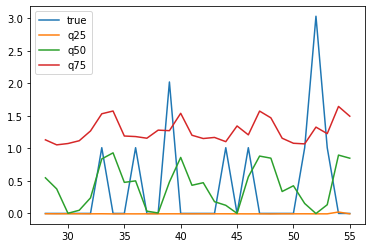

In [66]:
k = np.random.randint(0, 42840)
#k = np.random.randint(0, 200)
print(ids[k, 0])
plt.plot(np.arange(28, 56), Yv[k], label="true")
plt.plot(np.arange(28, 56), pv[k ,:, 3], label="q25")
plt.plot(np.arange(28, 56), pv[k ,:, 4], label="q50")
plt.plot(np.arange(28, 56), pv[k, :, 5], label="q75")
plt.legend(loc="best")
plt.show()

In [65]:
## Prediction

In [48]:
names = [f"F{i+1}" for i in range(28)]

In [49]:
names

['F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'F6',
 'F7',
 'F8',
 'F9',
 'F10',
 'F11',
 'F12',
 'F13',
 'F14',
 'F15',
 'F16',
 'F17',
 'F18',
 'F19',
 'F20',
 'F21',
 'F22',
 'F23',
 'F24',
 'F25',
 'F26',
 'F27',
 'F28']

In [50]:
piv = pd.DataFrame(ids[:, 0], columns=["id"])

In [51]:
piv.head(50)

,id
0,CA_1_FOODS
1,CA_1_FOODS_1
2,CA_1_FOODS_2
3,CA_1_FOODS_3
4,CA_1_HOBBIES
5,CA_1_HOBBIES_1
6,CA_1_HOBBIES_2
7,CA_1_HOUSEHOLD
8,CA_1_HOUSEHOLD_1
9,CA_1_HOUSEHOLD_2


In [52]:
sv

array([[4.658e+02, 4.658e+02, 4.658e+02, ..., 4.658e+02, 4.658e+02,
        4.658e+02],
       [5.641e+01, 5.641e+01, 5.641e+01, ..., 5.641e+01, 5.641e+01,
        5.641e+01],
       [8.494e+01, 8.494e+01, 8.494e+01, ..., 8.494e+01, 8.494e+01,
        8.494e+01],
       ...,
       [5.010e-01, 5.010e-01, 5.010e-01, ..., 5.010e-01, 5.010e-01,
        5.010e-01],
       [3.921e-01, 3.921e-01, 3.921e-01, ..., 3.921e-01, 3.921e-01,
        3.921e-01],
       [1.440e+03, 1.440e+03, 1.440e+03, ..., 1.440e+03, 1.440e+03,
        1.440e+03]], dtype=float16)

In [53]:
QUANTILES = ["0.005", "0.025", "0.165", "0.250", "0.500", "0.750", "0.835", "0.975", "0.995"]
VALID = []
EVAL = []

for i, quantile in tqdm(enumerate(QUANTILES)):
    t1 = pd.DataFrame(pv[:,:, i]*sv, columns=names)
    t1 = piv.join(t1)
    t1["id"] = t1["id"] + f"_{quantile}_validation"
    t2 = pd.DataFrame(pe[:,:, i]*se, columns=names)
    t2 = piv.join(t2)
    t2["id"] = t2["id"] + f"_{quantile}_evaluation"
    VALID.append(t1)
    EVAL.append(t2)

9it [00:00, 10.74it/s]


In [54]:
sv

array([[4.658e+02, 4.658e+02, 4.658e+02, ..., 4.658e+02, 4.658e+02,
        4.658e+02],
       [5.641e+01, 5.641e+01, 5.641e+01, ..., 5.641e+01, 5.641e+01,
        5.641e+01],
       [8.494e+01, 8.494e+01, 8.494e+01, ..., 8.494e+01, 8.494e+01,
        8.494e+01],
       ...,
       [5.010e-01, 5.010e-01, 5.010e-01, ..., 5.010e-01, 5.010e-01,
        5.010e-01],
       [3.921e-01, 3.921e-01, 3.921e-01, ..., 3.921e-01, 3.921e-01,
        3.921e-01],
       [1.440e+03, 1.440e+03, 1.440e+03, ..., 1.440e+03, 1.440e+03,
        1.440e+03]], dtype=float16)

In [55]:
sub = pd.DataFrame()
sub = sub.append(VALID + EVAL)
del VALID, EVAL, t1, t2

In [56]:
sub.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,CA_1_FOODS_0.005_validation,974.828064,926.406860,869.557739,927.701843,1033.359619,1306.793945,1420.298462,1128.437012,1051.758667,...,1097.958984,1345.949829,1431.606689,1085.698975,979.813904,954.132751,968.183289,1081.787476,1321.621094,1425.655640
1,CA_1_FOODS_1_0.005_validation,85.631836,79.305046,75.582336,84.240311,96.625000,115.758820,115.788651,87.032936,83.780525,...,99.298248,113.187263,102.645821,85.809418,81.284401,81.935249,91.725700,99.066032,114.713661,105.421944
2,CA_1_FOODS_2_0.005_validation,145.590256,134.907440,113.126183,122.066734,139.640640,184.366714,213.307297,183.932983,172.484604,...,159.852921,195.751907,209.846054,173.495026,146.690216,135.674118,126.511482,154.857742,185.397522,210.422272
3,CA_1_FOODS_3_0.005_validation,671.753052,643.583435,598.246582,639.210022,713.976807,923.347595,989.245728,762.239014,707.811951,...,750.089905,929.539062,1018.393494,748.862793,676.495300,660.662292,669.713684,745.429565,924.328735,1019.444641
4,CA_1_HOBBIES_0.005_validation,151.396637,141.064301,137.351318,142.754379,154.798233,190.219284,201.536270,164.435928,166.529114,...,164.828354,192.428391,191.558167,167.853821,152.576538,141.505630,144.036987,168.021393,197.656738,200.876373


In [57]:
sub.to_csv("5_submission.csv", index=False)